In [12]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the SQLite database URI
db_uri = 'sqlite:///gohiring.db'

# Create an SQLAlchemy engine
engine = create_engine(db_uri)

# Let's define SQL statements for creating tables
create_table_dim_companies = '''
    CREATE TABLE IF NOT EXISTS dim_companies (
        "company_id" INTEGER PRIMARY KEY,
        "company_name" TEXT,
        "establishment_date" TEXT,
        "number_of_employees" INTEGER
    )
'''

create_table_dim_locations = '''
    CREATE TABLE IF NOT EXISTS dim_locations (
        "location_id" INTEGER PRIMARY KEY,
        "zip_code" INTEGER,
        "location" TEXT
    )
'''

create_table_fact_jobs = '''
    CREATE TABLE IF NOT EXISTS fact_jobs (
        "job_id" INTEGER,
        "posted_at" TEXT,
        "company_id" INTEGER,
        "location_id" INTEGER,
        "state" TEXT,
        "price" NUMERIC,
        PRIMARY KEY (job_id, company_id, location_id, state)
    )
'''

In [13]:
# Let's define SQL statements to drop tables in case they already exist
drop_table_dim_companies = 'DROP TABLE IF EXISTS dim_companies'
drop_table_fact_jobs = 'DROP TABLE IF EXISTS dim_jobs'
drop_table_dim_locations = 'DROP TABLE IF EXISTS dim_locations'

# Execute the SQL statements
with engine.connect() as conn:
    conn.execute(drop_table_dim_companies)
    conn.execute(drop_table_dim_locations)
    conn.execute(drop_table_fact_jobs)
    conn.execute(create_table_dim_companies)
    conn.execute(create_table_dim_locations)
    conn.execute(create_table_fact_jobs)

In [14]:
# ******************************************** Data Loading *********************************************

# Read data from JSON files into DataFrames
companies_data = pd.read_json('data/companies.json')
jobs_data = pd.read_json('data/jobs.json')
locations_data = pd.read_csv('data/locations.csv')

# Data Quality
companies_data['Establishment Date'] = pd.to_datetime(companies_data['Establishment Date'], unit='ms', origin='unix')
jobs_data['state'] = jobs_data['state'].replace({'cancelled': 'canceled', 'osted': 'posted'})
jobs_data = jobs_data.drop_duplicates(keep='first')
    
# Rename columns to match SQLite table schema
companies_data.rename(columns={
    'Company ID': 'company_id',
    'Company Name': 'company_name',
    'Establishment Date': 'establishment_date',
    'Number of Employees': 'number_of_employees'
}, inplace=True)

jobs_data.rename(columns={
    'id': 'job_id'
}, inplace=True)

locations_data['location_id'] = np.arange(1, len(locations_data) + 1)
jobs_locations_data = jobs_data.merge(locations_data, left_on="zip", right_on="zip_code", how="inner")
columns = ["job_id","posted_at","company_id","location_id","state","price"]
jobs_data = jobs_locations_data[columns]

# Insert data into the SQLite tables
companies_data.to_sql('dim_companies', engine, if_exists='replace', index=False)
jobs_data.to_sql('fact_jobs', engine, if_exists='replace', index=False)
locations_data.to_sql('dim_locations', engine, if_exists='replace', index=False)

8

In [35]:
# Let's check if the tables have been filled
table_names = ['dim_companies', 'fact_jobs', 'dim_locations']

for table_name in table_names:
    with engine.connect() as conn:
        query = f'SELECT COUNT(*) FROM {table_name}'
        result = conn.execute(query)
        row_count = result.scalar()
        print(f'Table: {table_name}, Row Count: {row_count}')

Table: dim_companies, Row Count: 10
Table: fact_jobs, Row Count: 100
Table: dim_locations, Row Count: 8


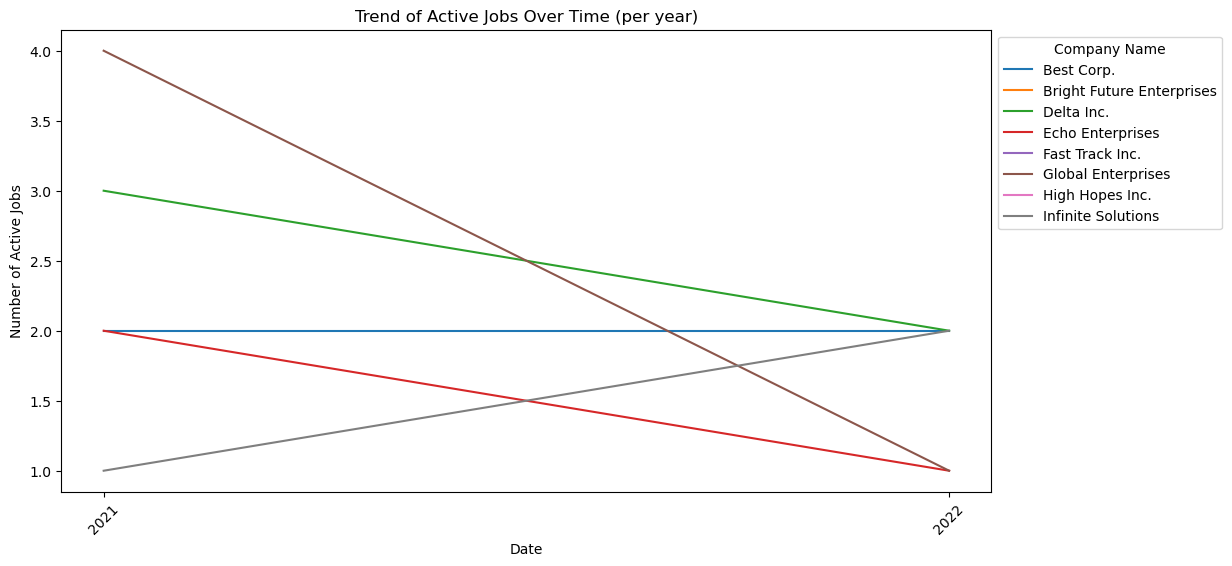

In [30]:
# 7. Provide a visualization showing the trend of the number of active jobs over time.
# Also include the company name data in this visualization.
# ************************** Trend of Active Jobs Over Time (per year) **************************
active_jobs_per_company = '''
    SELECT company_name,
            strftime('%Y', posted_at) AS posted_at_year,
           COUNT(job_id) AS Active_jobs
    FROM fact_jobs j
    INNER JOIN dim_companies c
        ON j.company_id = c.company_id
    WHERE j.state = 'posted'
    GROUP BY company_name,
            posted_at_year
    ORDER BY company_name,
             posted_at_year
'''

active_jobs_df = pd.read_sql_query(active_jobs_per_company, engine)

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(x='posted_at_year', y='Active_jobs', hue='company_name', estimator='count',data=active_jobs_df)
plt.title('Trend of Active Jobs Over Time (per year)')
plt.xlabel('Date')
plt.ylabel('Number of Active Jobs')
plt.xticks(rotation=45)
plt.legend(title='Company Name', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

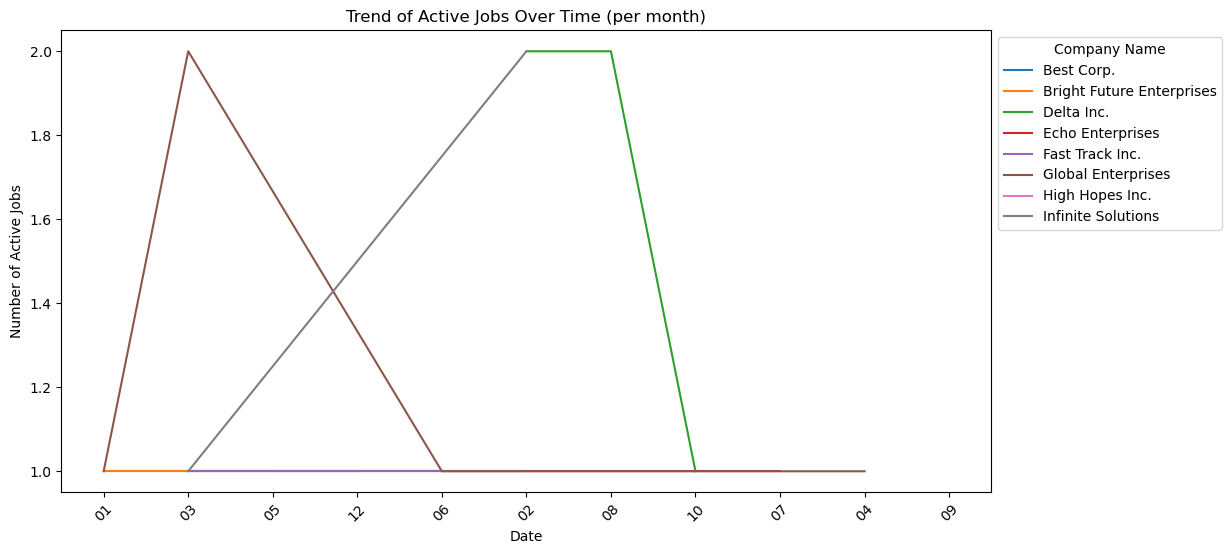

In [31]:
# ************************** Trend of Active Jobs Over Time (per month) **************************
active_jobs_per_company = '''
    SELECT company_name,
            strftime('%m', posted_at) AS posted_at_month,
           COUNT(job_id) AS Active_jobs
    FROM fact_jobs j
    INNER JOIN dim_companies c
        ON j.company_id = c.company_id
    WHERE j.state = 'posted'
    GROUP BY company_name,
            posted_at_month
    ORDER BY company_name,
             posted_at_month
'''

active_jobs_df = pd.read_sql_query(active_jobs_per_company, engine)

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(x='posted_at_month', y='Active_jobs', hue='company_name', estimator='count',data=active_jobs_df)
plt.title('Trend of Active Jobs Over Time (per month)')
plt.xlabel('Date')
plt.ylabel('Number of Active Jobs')
plt.xticks(rotation=45)
plt.legend(title='Company Name', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()